Made by : mina ramsis

in this notebook , we implement a Face recognition model that uses Convolutional neural network to detect faces with thier personal identities using a library called lfw_people that has an enourmous dataset of sample data of fake people with thier corresponding faces for model training purposes to this project so, lets get started :

we first implemented needed libraries needed :

Uses TensorFlow/Keras for the CNN, scikit-learn for metrics, and other necessary libraries for data handling and visualization.
Loads Dataset: Fetches the LFW dataset with a minimum of 70 faces per person to ensure sufficient samples per class.

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_lfw_people
import cv2

In [5]:
# Step 2: Loading the LFW dataset
def load_lfw_dataset(min_faces=70):
    lfw_people = fetch_lfw_people(min_faces_per_person=min_faces, resize=0.4)
    X = lfw_people.images
    y = lfw_people.target
    target_names = lfw_people.target_names
    return X, y, target_names

X, y, target_names = load_lfw_dataset()
n_classes = len(target_names)

 the preprocessing of the Labeled Faces in the Wild (LFW) dataset is handled in the preprocess_images function

***1.Reshaping the Images:***

What was done: The images from the LFW dataset were reshaped to include a channel dimension, transforming the shape from (n_samples, height, width) to (n_samples, height, width, 1). This is because the LFW dataset provides grayscale images, and TensorFlow’s CNN layers expect input in the format (batch_size, height, width, channels).
Why it’s important: CNNs in TensorFlow/Keras require a defined input shape that includes the number of channels (1 for grayscale, 3 for RGB). Adding the channel dimension ensures compatibility with the model’s convolutional layers.


***2.Normalization:***

What was done: Pixel values of the images were converted to float32 and divided by 255, scaling them from [0, 255] to [0, 1].
Why it’s important: Normalization stabilizes and accelerates training by ensuring that input features have a consistent scale. Large pixel values can lead to unstable gradients, slowing convergence or causing the model to fail to learn effectively.


***3.Data Augmentation Setup:***

  What was done: A Keras ImageDataGenerator was configured to apply random transformations during training, including:
Rotation: Up to 10 degrees.
Width/Height Shifts: Up to 10% of the image dimensions.
Horizontal Flips: Randomly flipping images left-to-right.
Why it’s important: Data augmentation artificially increases the dataset size and diversity by generating modified versions of images. This helps prevent overfitting, especially for small datasets like LFW, and makes the model more robust to variations in face orientation, position, or lighting

In [6]:
# Step 2: Loading the LFW dataset
def load_lfw_dataset(min_faces=70):
    lfw_people = fetch_lfw_people(min_faces_per_person=min_faces, resize=0.4)
    X = lfw_people.images
    y = lfw_people.target
    target_names = lfw_people.target_names
    return X, y, target_names

X, y, target_names = load_lfw_dataset()
n_classes = len(target_names)

# Step 3: Image preprocessing
def preprocess_images(images):
    # Reshape
    images = images.reshape(-1, images.shape[1], images.shape[2], 1)
    print("After reshaping:")
    print(f"  Shape: {images.shape}")
    print(f"  Data type: {images.dtype}")

    # Normalize
    images = images.astype('float32') / 255.0
    print("\nAfter normalization:")
    print(f"  Min pixel value: {images.min():.4f}")
    print(f"  Max pixel value: {images.max():.4f}")
    print(f"  Data type: {images.dtype}")

    # Data augmentation
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    print("\nData augmentation configuration:")
    print("  Rotation range: 10 degrees")
    print("  Width shift range: 10%")
    print("  Height shift range: 10%")
    print("  Horizontal flip: Enabled")

    return images, datagen

X_processed, datagen = preprocess_images(X)


After reshaping:
  Shape: (1288, 50, 37, 1)
  Data type: float32

After normalization:
  Min pixel value: 0.0000
  Max pixel value: 0.0039
  Data type: float32

Data augmentation configuration:
  Rotation range: 10 degrees
  Width shift range: 10%
  Height shift range: 10%
  Horizontal flip: Enabled


In [7]:
# Step 4: Define and load the CNN model
def create_cnn_model(input_shape, n_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    return model

model = create_cnn_model(input_shape=(X_processed.shape[1], X_processed.shape[2], 1), n_classes=n_classes)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)




***Configures the model with:***

  Adam optimizer with a low learning rate (0.0001) for stable updates.
sparse_categorical_crossentropy loss function, suitable for multi-class classification with integer labels.
accuracy metric to monitor performance.
Training: Trains the model for 20 epochs with a batch size of 32, using:
Augmented training data via datagen.flow, which applies random transformations to X_train.
Validation data (X_test, y_test) to evaluate performance after each epoch.
verbose=1 to display training progress.
Stores training history (loss, accuracy, validation metrics) in history.


***Compilation:***

 Sets up the optimization process, defining how the model learns (via Adam) and measures performance (via loss and accuracy).
Training: Updates model weights to minimize the loss, learning to recognize faces. Data augmentation enhances robustness.
Validation: Monitors performance on the test set to detect overfitting or underfitting.

***Contribution:***

Optimizes the model to classify faces accurately, leveraging augmentation to improve generalization.

In [8]:

# Step 5: Compile and train the model with low learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 20

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.3693 - loss: 1.9412 - val_accuracy: 0.4612 - val_loss: 1.8979
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.3896 - loss: 1.8702 - val_accuracy: 0.4612 - val_loss: 1.6495
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.3703 - loss: 1.7740 - val_accuracy: 0.4612 - val_loss: 1.6201
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.3907 - loss: 1.7526 - val_accuracy: 0.4612 - val_loss: 1.6176
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.3757 - loss: 1.7677 - val_accuracy: 0.4612 - val_loss: 1.6056
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.3755 - loss: 1.7730 - val_accuracy: 0.4612 - val_loss: 1.6065
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.4539 - loss: 1.6549 - val_accuracy: 0.4612 - val_loss: 1.6243
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.3935 - loss: 1.7362 - val_accuracy: 0.4612 - val_loss:


***Predictions:***

Uses the model to predict on X_test, converting probabilities to class labels via np.argmax.

***Metrics:***

*Accuracy:*

 Proportion of correct predictions.

*Precision:*

 Weighted average of true positives over predicted positives per class.

*Recall:*

 Weighted average of true positives over actual positives per class.

*F1 Score:*

 Harmonic mean of precision and recall, weighted by class.

*Confusion Matrix:*

 Generates a heatmap showing true vs. predicted labels, saved as confusion_matrix.png.
Training History Plots: Plots training and validation accuracy/loss over epochs, saved as training_history.png.
Calls the function to evaluate the model.

*History Plots:*

 Tracks training progress, revealing trends like overfitting (if validation loss increases) or underfitting (if both losses remain high).
Contribution: Provides a comprehensive evaluation of the model’s effectiveness, enabling assessment of its face recognition capabilities and identification of potential improvements.

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.4612
Precision: 0.2127
Recall: 0.4612
F1 Score: 0.2912


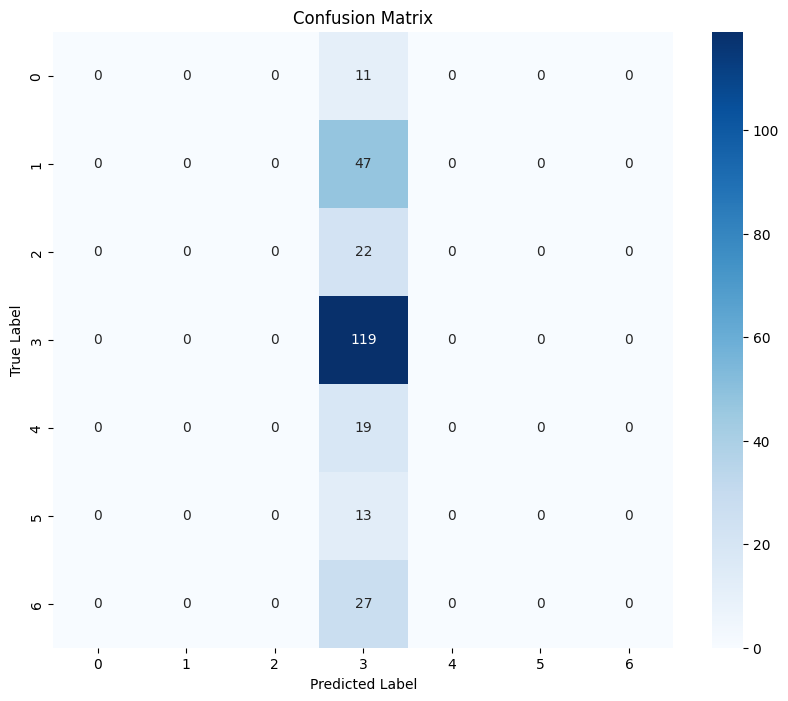

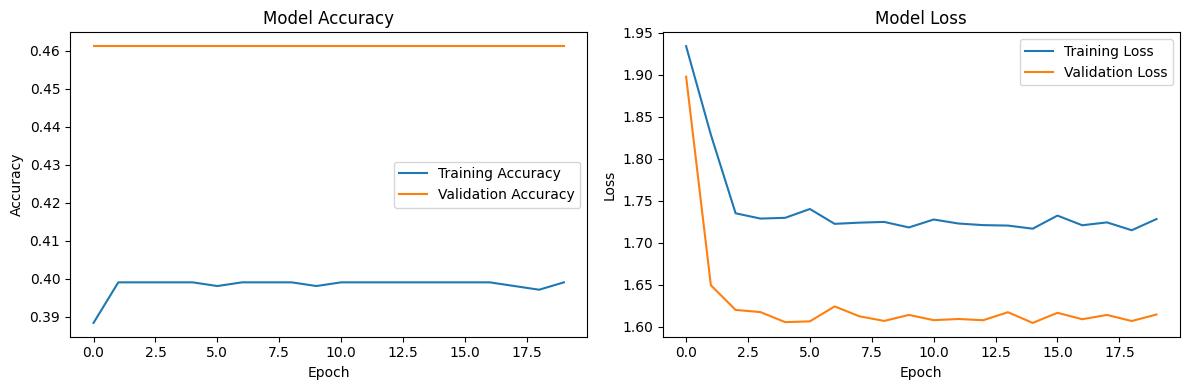

In [9]:
# Step 6: Evaluate model performance
def evaluate_model(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')

evaluate_model(model, X_test, y_test)